# Dunnhumby dataset

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from IPython.display import Image

We load our dataset.

In [2]:
product = pd.read_csv('data/product.csv')
coupon = pd.read_csv('data/coupon.csv')
coupon = coupon.drop_duplicates(keep='first')
campaign = pd.read_csv('data/campaign_desc.csv')
trans = pd.read_csv('data/transaction_data.csv')
demographic = pd.read_csv('data/hh_demographic.csv')
campaign_table = pd.read_csv('data/campaign_table.csv')
coupon_redemption = pd.read_csv('data/coupon_redempt.csv')

Our dataset is composed of several tables:
* __product__ : This table contains information on each product sold such as type of product, department, brand identifier.


* __trans__ : This table contains all products purchased by households within this study.


* __demographic__ : This table contains demographic information for a portion of households, like the marital status, age description, household composition. 


* __campaign__ : This table lists the campaigns received by each household in the study. 


* __campaign_table__ : This table gives the length of time for which a campaign runs. So, any coupons received as part of a campaign are valid within the dates contained in this table.


* __coupon__ : This table lists all the coupons sent to customers as part of a campaign, as well as the products for which each coupon is redeemable. 


* __coupon_redemption__: This table identifies the coupons that each household redeemed.

The following table is taken from the documentation of the dataset, which describes the relationships of the various dataframes described above.

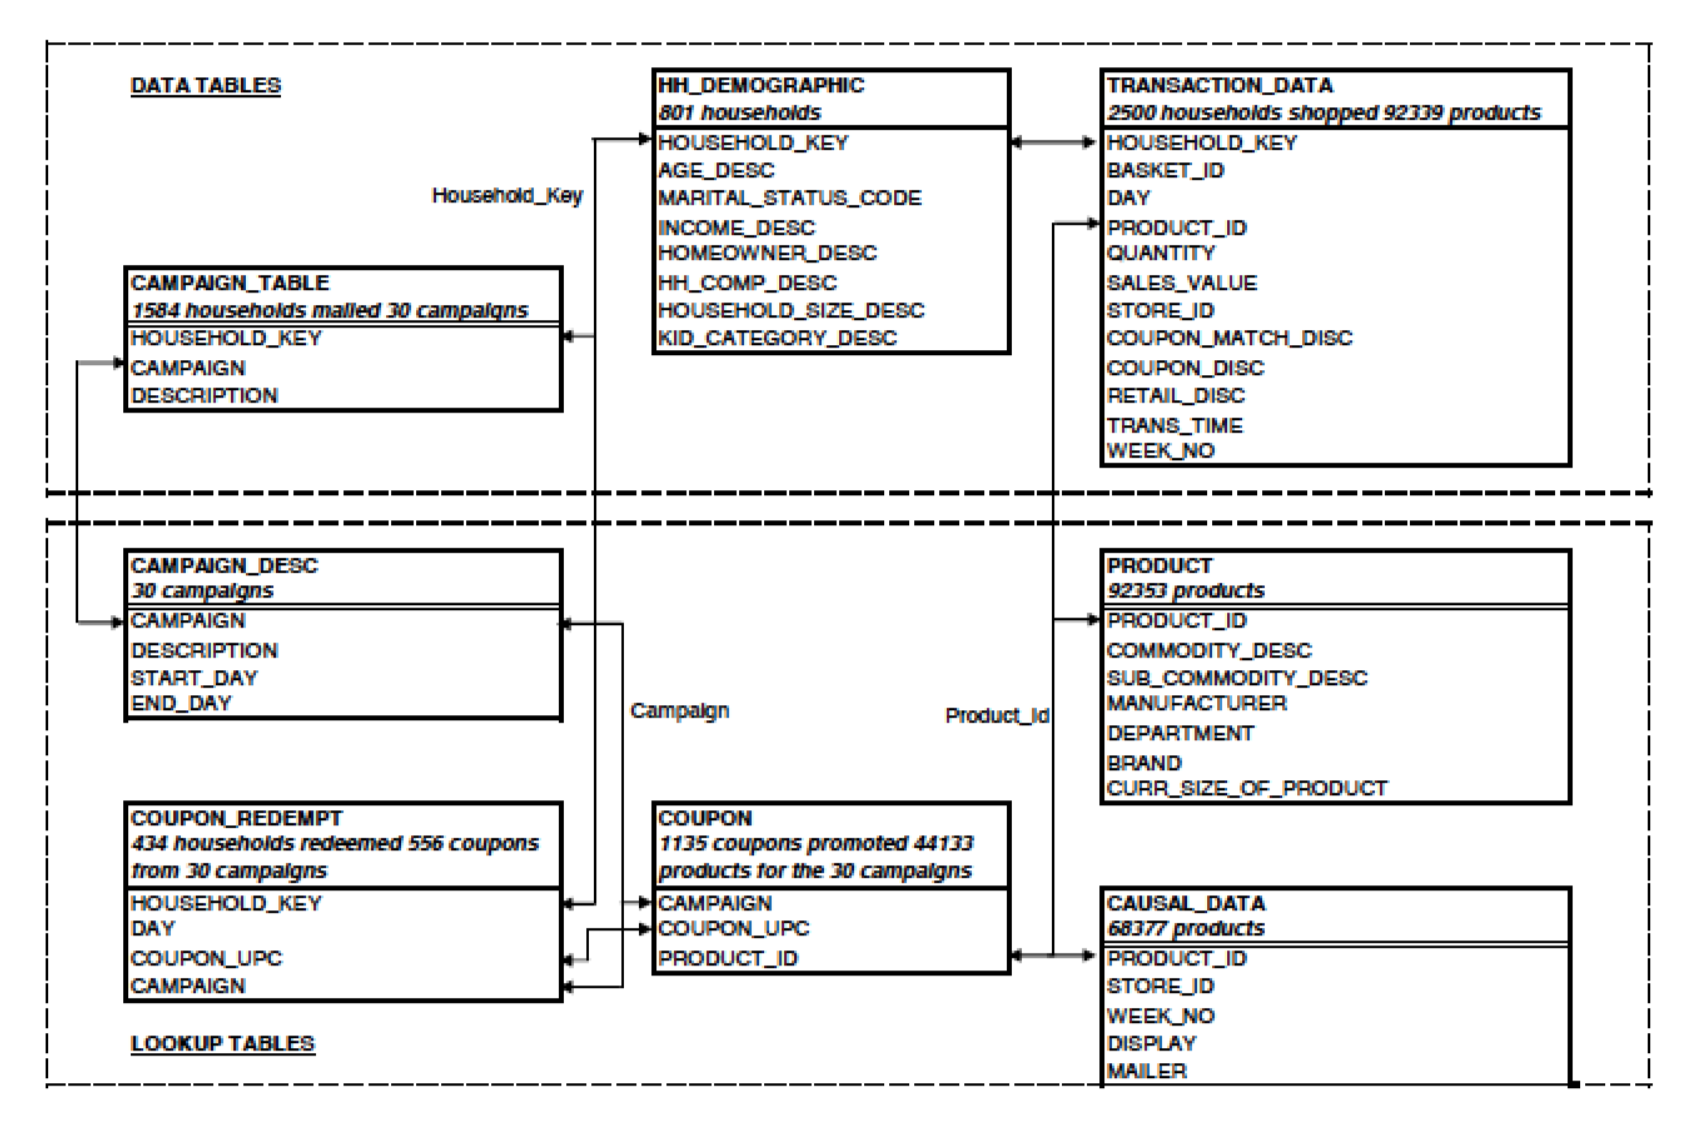

In [3]:
Image('./data/tables.png', width=800,height=600)

# 1. Exploration on our dataset

We start with a general exploration of our dataset.

## A. Demographic distribution

First, we will concentrate in analyzing the demographic distribution of the families who provided their demographical infomations.

In [4]:
demographic.head(2)

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


First, we note there are 2 non-numerical columns that contains range, therefore we expand them so that we will able to easily split family in our analysis based on some income/age characteristic.

In [197]:
age_levels = demographic['AGE_DESC'].drop_duplicates().to_frame()
age_levels['MIN_AGE'] = age_levels['AGE_DESC'].apply(lambda x : int(x[:2]))
age_levels = age_levels.set_index('AGE_DESC')

In [198]:
age_levels

,MIN_AGE
AGE_DESC,
65+,65
45-54,45
25-34,25
35-44,35
19-24,19
55-64,55


In [199]:
demographic['MIN_AGE'] = demographic['AGE_DESC'].apply(lambda x: age_levels.loc[x])

Also, we plot the age distribution for those families.

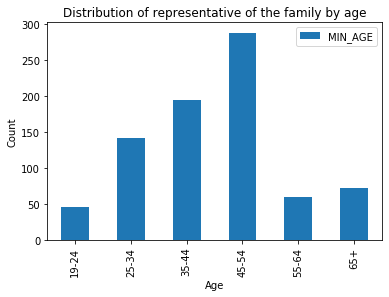

In [200]:
demographic.groupby('AGE_DESC')[['MIN_AGE']].count().plot.bar()
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of representative of the family by age')
plt.show()

Then, we repeat the same operation for the incomes.

In [201]:
income_levels = demographic['INCOME_DESC'].drop_duplicates().to_frame()
min_income = lambda x: 0 if x.startswith('U') else int(x[:x.find('-') if '-' in x else 3])
max_income = lambda x: 250 if x.endswith('+') else int(x[max(x.find(' '), x.find('-')) + 1:x.find('K')]) # Maxincome for 250K+ ??
income_levels['MIN_INCOME'] = income_levels['INCOME_DESC'].apply(lambda x : min_income(x))
income_levels['MAX_INCOME'] = income_levels['INCOME_DESC'].apply(lambda x : max_income(x))
income_levels = income_levels.set_index('INCOME_DESC')
income_levels

,MIN_INCOME,MAX_INCOME
INCOME_DESC,,
35-49K,35,49
50-74K,50,74
25-34K,25,34
75-99K,75,99
Under 15K,0,15
100-124K,100,124
15-24K,15,24
125-149K,125,149
150-174K,150,174


In [202]:
demographic[['MIN_INCOME', 'MAX_INCOME']] = demographic['INCOME_DESC'].apply(lambda x: income_levels.loc[x])

In [203]:
income_plot = income_levels[['MIN_INCOME']].copy()
income_plot['INCOME_DESC'] = demographic['INCOME_DESC'].value_counts()

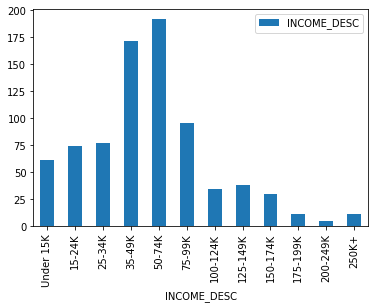

In [204]:
income_plot.sort_values(by='MIN_INCOME')[['INCOME_DESC']].plot.bar()

Again, here we plotted the distribution of the incomes for the families who decided to provide those information.

## B. Transaction history

Now, we take a closer look to the transactions we have.

In [205]:
def plot_weekly_avg_sales(trans):
    
    avg_sales = trans.groupby('WEEK_NO')['SALES_VALUE'].sum().apply(lambda x: x/7)
    
    avg_sales.plot()
    plt.xlabel('Week number')
    plt.ylabel('Average sales by day [$]')
    plt.title('Evolution of the average sales through the weeks')

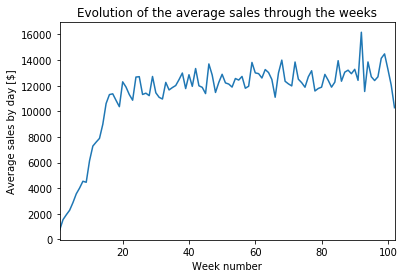

In [206]:
plot_weekly_avg_sales(trans)

We notice that the average sales by day increase very fast during the first 20 weeks which seems odd. This could be because not all households have signed up for the survey yet, so their transaction history isn't being recorded yet.

Let's test this hypothesis. For each household, we find out the day in which they did their first transaction. While we're at it, let's also find out the day of their last transaction.

We plot a cumulative distribution of this first-transaction day.

In [207]:
trans_days = trans.groupby('household_key')['DAY'].min().to_frame().rename(columns={'DAY': 'FIRST DAY'})
trans_days['LAST DAY'] = trans.groupby('household_key')['DAY'].max()

[]

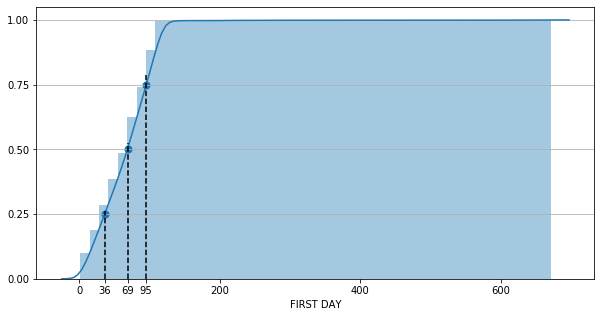

In [208]:
trans_distr = pd.DataFrame([trans_days.quantile(perc) for perc in np.arange(0.25, 1, 0.25)])
first_days_distr = trans_distr['FIRST DAY'].tolist()

fig, ax = plt.subplots(figsize=(10, 5)) 
g = sns.distplot(trans_days['FIRST DAY'],
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True))
g.set(xticks=list(range(0, 800, 200)) + first_days_distr)
g.set(yticks=np.arange(0, 1.1, 0.25))
plt.scatter(first_days_distr, trans_distr.index, marker='o', s=50)
for x,y in zip(first_days_distr, trans_distr.index):
    plt.axvline(x=x, color='k', linestyle='--', ymax=y)
ax.yaxis.grid(True)
g.plot()

It seems as if by day 100, all households have already made their first transaction.

So, we were not recording transaction history until week 20. The registration rate seems to be more or less constant, so by **day 69**, for instance, only **half the households** were recording their transactions and therefore we would expect the sales average to be **half of what it was at the end** of the survey.

We can compare the average sale per day during week 10 (~half-households) and 20 (all households).

In [209]:
print('Average sales per day during week 10: {:f} $'\
      .format(trans[trans['WEEK_NO'] == 10]['SALES_VALUE'].sum()/7))
print('Average sales per day between week 20 and the end of the survey: {:f} $'\
      .format(trans[trans['WEEK_NO'] > 20]['SALES_VALUE'].sum()/(711-20*7)))

Average sales per day during week 10: 6142.054286 $
Average sales per day between week 20 and the end of the survey: 12509.549825 $


This confirms our hypothesis. We might then only want to consider transactions that happened after week 20 so we are sure that the full household population is active.

This brings another question: did some of the households stop shopping before the end of the survey?

Let's plot the cumulative distribution of the day of the last transaction for every household.

FIRST DAY     30.0
LAST DAY     684.0
Name: 0.2, dtype: float64

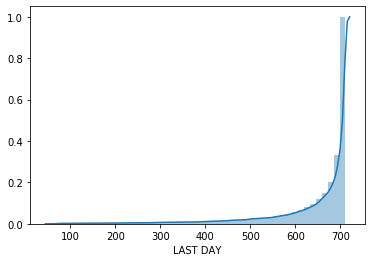

In [213]:
sns.distplot(trans_days['LAST DAY'],
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True))
trans_days.quantile(0.2)

Progressively, some of the households seem to be abandoning the survey but by day 680 (~30 days before the end of the survey) more than 80% of the houshoolds are still making transactions.

## C. Product distributions

We will analyze the products sold by department, the stores for which we have the data may be selling particular kinds of product.

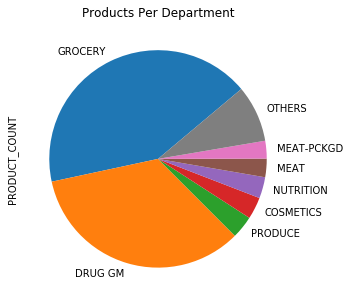

In [62]:
dept_count = product.groupby('DEPARTMENT').count().rename(columns={'MANUFACTURER':'PRODUCT_COUNT'})['PRODUCT_COUNT']
tmp = dept_count.sort_values(ascending=False).to_frame()
others_product_ct = sum(tmp[tmp['PRODUCT_COUNT']<2400]['PRODUCT_COUNT'])
tmp[tmp['PRODUCT_COUNT']>2400].reset_index().\
            append({'DEPARTMENT':'OTHERS', 'PRODUCT_COUNT':others_product_ct}, ignore_index=True).\
            set_index('DEPARTMENT').\
            plot.pie(y='PRODUCT_COUNT', figsize=(10, 5),title='Products Per Department', legend=None, startangle=40)

As seen above, the major departments are 'GROCERY' and 'DRUG GM'. Together they make up more than 2/3 of the total products.

Now, we want to see which kind of product constitutes these departments.

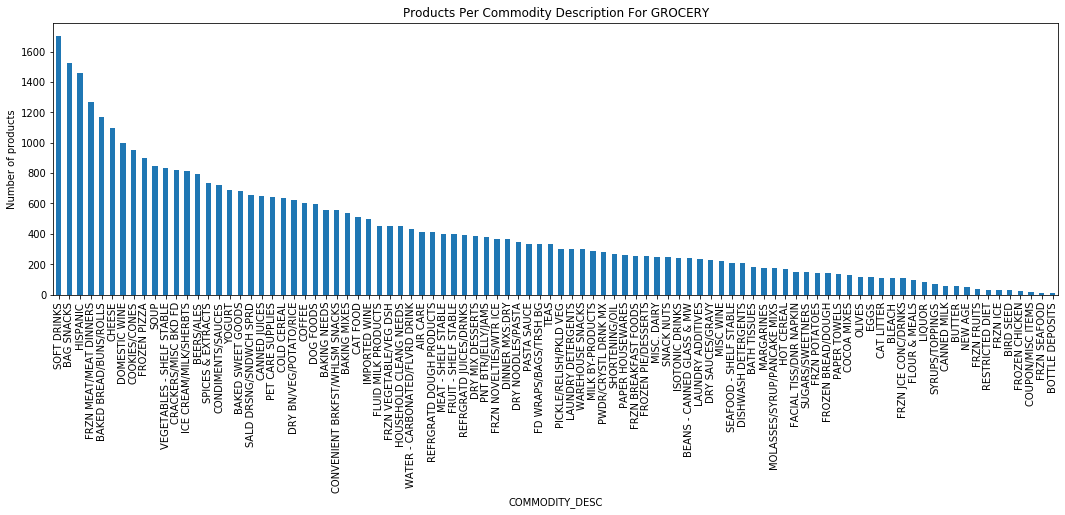

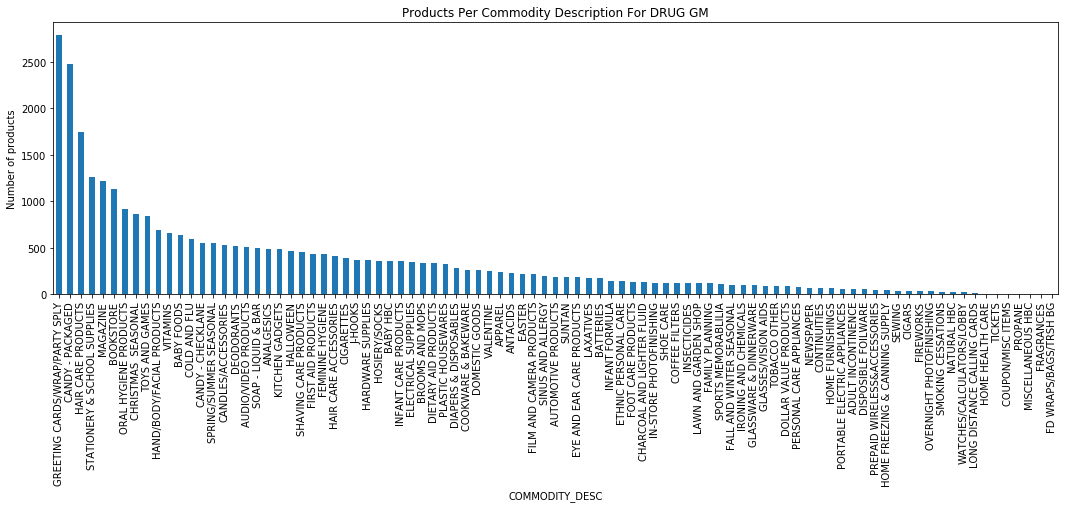

In [225]:
#Since most of the products are of the cathegory 'GROCERY' or 'DRUG GM', 
# priting the amount of products per 'COMMODITY_DESC'
best_departments = ['GROCERY', 'DRUG GM']
for dep in best_departments:
    commodity_count = product[product['DEPARTMENT']== dep].groupby('COMMODITY_DESC').count()\
    .rename(columns={'MANUFACTURER':'PRODUCT_COUNT'})['PRODUCT_COUNT']
    commodity_count.sort_values(ascending=False).plot.bar(y='PRODUCT_COUNT', figsize=(18, 5), title='Products Per Commodity Description For ' + dep)
    plt.ylabel('Number of products')
    plt.show()

## D. Coupons

We analyze the products on which the coupons are issued, and group by department to see if the distribution reflects the one in the previous section. 

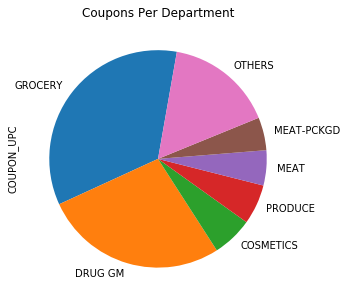

In [171]:
coupon_by_dept = coupon.groupby('PRODUCT_ID').agg('count').sort_values('COUPON_UPC', ascending=False).\
                join(product, how='left').\
                groupby('DEPARTMENT').agg('count').sort_values('COUPON_UPC', ascending=False)['COUPON_UPC'].\
                to_frame()

others_ct = sum(coupon_by_dept[coupon_by_dept['COUPON_UPC']<1000]['COUPON_UPC'])
coupon_by_dept[coupon_by_dept['COUPON_UPC']>1000].reset_index().\
            append({'DEPARTMENT':'OTHERS', 'COUPON_UPC':others_product_ct}, ignore_index=True).\
            set_index('DEPARTMENT').\
            plot.pie(y='COUPON_UPC', figsize=(10, 5),title='Coupons Per Department', legend=None, startangle=80)

We observe that 'GROCERY' and 'DRUG GM' which were the 2 major departments also have the largest number of coupon associated with them. <br>
Now we focus on the redemmed coupons. We filter out the transactions in which coupons were used.

In [238]:
products_redeemed = coupon_redemption.merge(coupon, on=['COUPON_UPC', 'CAMPAIGN'])
coupon_trans = trans[(trans['COUPON_DISC'] < 0) | (trans['COUPON_MATCH_DISC'] < 0) | (trans['RETAIL_DISC'] < 0)] \
                .merge(products_redeemed, on=['household_key', 'DAY', 'PRODUCT_ID'])

Text(0.5, 1.0, 'Discount in dollars per department')

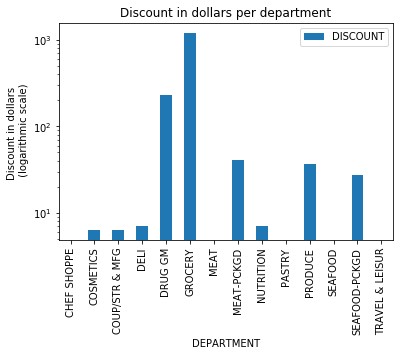

In [242]:
prod = product.reset_index()[['PRODUCT_ID', 'DEPARTMENT']].copy()
disc = coupon_trans.copy()
disc['DISCOUNT'] = -(disc['COUPON_DISC'] + disc['COUPON_MATCH_DISC'] + disc['RETAIL_DISC'])
total_disc = t.merge(prod, on='PRODUCT_ID').groupby('DEPARTMENT').sum()['DISCOUNT'].to_frame().plot.bar()
plt.yscale('log')
plt.ylabel('Discount in dollars \n (logarithmic scale)')
plt.title('Discount in dollars per department')

The above plot shows the total discount obtained by using coupons per department.

We notice that COSMETICS is one of the department with the highest number of coupon associated but issue quite a little total discount. This can be due to a low usage of coupons in this particular department or maybe because each coupon apply really little discount. 

We cannot recover exactly how many coupons are issued for each department, from the documentation of our dataset: <br>
_"For campaign TypeA, this table provides the pool of possible coupons. Each customer participating in a TypeA campaign received 16 coupons out of the pool. The 16 coupons were selected based on the customer’s prior purchase behavior. Identifying the specific 16 coupons that each customer received is outside the scope of this database."_

Therefore, we cannot verify our first hypothesis but we will try to compare the average discount for coupon per department.

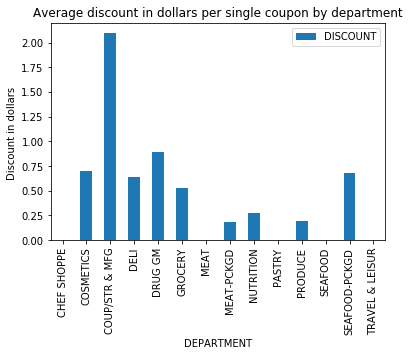

In [243]:
disc['DISCOUNT'] = -(disc['COUPON_DISC'] + disc['COUPON_MATCH_DISC']) / disc['QUANTITY']
total_disc = t.merge(prod, on='PRODUCT_ID').groupby('DEPARTMENT').mean()['DISCOUNT'].to_frame().plot.bar()
plt.title('Average discount in dollars per single coupon by department')
plt.ylabel('Discount in dollars ')
plt.show()

# Impacts of coupons

In this section we analyse the impact of coupons by considering how coupons are redeemed, for which products, and how the sales vary. We explain in detail below the factors which we consider.

In [5]:
products_redeemed = coupon_redemption.merge(coupon, on=['COUPON_UPC', 'CAMPAIGN'])

coupon_trans = trans[(trans['COUPON_DISC'] < 0) | (trans['COUPON_MATCH_DISC'] < 0) | (trans['RETAIL_DISC'] < 0)] \
                .merge(products_redeemed, on=['household_key', 'DAY', 'PRODUCT_ID'])

print('We found {} transactions where coupons were used and the COUPON REDEMPTION table had {} entries, so some coupons affected several products in one single basket.'\
     .format(coupon_trans.shape[0], coupon_redemption.shape[0]))

We found 3186 transactions where coupons were used and the COUPON REDEMPTION table had 2318 entries, so some coupons affected several products in one single basket.


We measure the impact of a coupon transaction on one household by computing several statistics such as:
- total sales before and after
- average sales before and after (per day)
- average sales difference (per day)
- predicted total sales increase *(computed as the difference between the total sales after and the predicted total sales if the average sales per day had remained the same as before)*

*Note: We take into account the fact that some families started recording their transaction history later than others in this analysis.*

In [8]:
def compute(trans, day, day_zero=0):

    trans_before = trans[trans['DAY'] < day]
    trans_after = trans[trans['DAY'] >= day]

    total_sales_before = trans_before['SALES_VALUE'].sum()
    total_sales_after = trans_after['SALES_VALUE'].sum()

    avg_sales_before = total_sales_before/(day-day_zero)
    avg_sales_after = total_sales_after/(711-day)
    avg_diff = avg_sales_after - avg_sales_before
    
    pred_total_sales_increase = total_sales_after - (711-day) * avg_sales_before

    return [total_sales_before, total_sales_after, avg_sales_before, avg_sales_after, avg_diff, pred_total_sales_increase]

In [11]:
scores = pd.DataFrame(columns=['Total sales before', 'Total sales after', 'Average sales before', 'Average sales after', \
                               'Average sales difference', 'Predicted total sales increase', \
                               'household_key', 'PRODUCT_ID', 'DAY', 'COUPON_UPC', 'CAMPAIGN'])

for i, t in coupon_trans.iterrows():
    household_key = t['household_key']
    product_id = t['PRODUCT_ID']
    day = t['DAY']
    coupon_upc = t['COUPON_UPC']
    campaign_ = t['CAMPAIGN']
    day_zero = trans_days.loc[household_key]['FIRST_DAY']
    selected_trans = trans[(trans['PRODUCT_ID'] == product_id) & (trans['household_key'] == household_key)]
    scores.loc[i] = compute(selected_trans, day, day_zero) + [household_key, product_id, day, coupon_upc, campaign_]

scores = scores.astype({'household_key': 'int64', 'PRODUCT_ID': 'int64', 'DAY': 'int64', 'COUPON_UPC': 'int64', 'CAMPAIGN': 'int64'})
#scores.set_index(['household_key', 'PRODUCT_ID', 'DAY', 'COUPON_UPC', 'CAMPAIGN'], inplace=True)

scores.head()

,Total sales before,Total sales after,Average sales before,Average sales after,Average sales difference,Predicted total sales increase,household_key,PRODUCT_ID,DAY,COUPON_UPC,CAMPAIGN
0,14.26,3.24,0.081954,0.006667,-0.075287,-36.589655,2280,1139915,225,57008510075,26
1,0.00,2.69,0.000000,0.005546,0.005546,2.690000,2240,6039659,226,53600000001,26
2,6.67,3.34,0.040671,0.006901,-0.033770,-16.344634,788,895680,227,57218020076,26
3,0.00,3.48,0.000000,0.007190,0.007190,3.480000,788,899736,227,55100055008,26
4,0.00,1.74,0.000000,0.003595,0.003595,1.740000,788,954495,227,55100055008,26


# Campaign success

Let's sum the predicted total sales increase by campaign so we can get an idea of how succesful each campaign was. 

In [575]:
scores.groupby('CAMPAIGN')[['Predicted total sales increase']].sum() \
.sort_values('Predicted total sales increase', ascending=False)

,Predicted total sales increase
CAMPAIGN,
18,4097.444923
13,3068.408493
8,2146.053370
9,296.547034
23,269.245123
30,264.074029
19,260.298886
25,200.215435
22,191.582775


Campaigns 18, 13 and 8 really stand out. Because the statistic used for comparison takes the total sales after the coupon was used, it might be that these campaigns took place earlier than the rest which would explain this big gap.

We also notice that some of the campaigns have a negative predicted total sales increase, but this wouldn't be particularly alarming because it could be due to some seasonal effect.

[Text(0, 0.5, 'Campaign predicted total sales increase [$]'),
 Text(0.5, 0, 'First day of the campaign'),
 Text(0.5, 1.0, 'Predicted total sales increase vs. start day of the campaign')]

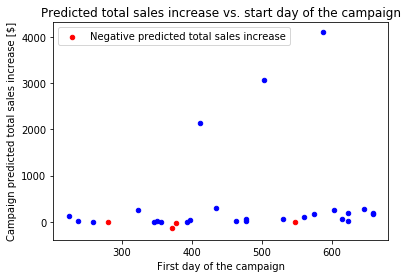

In [12]:
fig, ax = plt.subplots()

tmp = scores.groupby('CAMPAIGN')[['Predicted total sales increase']].sum() \
      .merge(campaign, left_index=True, right_on='CAMPAIGN')

tmp_pos = tmp[tmp['Predicted total sales increase'] > 0]
tmp_neg = tmp[tmp['Predicted total sales increase'] < 0]

tmp_pos.plot.scatter(x='START_DAY', y='Predicted total sales increase', marker='o', c='b', ax=ax)
tmp_neg.plot.scatter(x='START_DAY', y='Predicted total sales increase', marker='o', c='r', ax=ax, label='Negative predicted total sales increase')

ax.set(ylabel='Campaign predicted total sales increase [$]', xlabel='First day of the campaign', title='Predicted total sales increase vs. start day of the campaign')

In [15]:
scores = pd.DataFrame(columns=['Total sales before', 'Total sales after', 'Average sales before', 'Average sales after', \
                               'Average sales difference', 'Predicted total sales increase', \
                               'household_key', 'PRODUCT_ID', 'DAY', 'COUPON_UPC', 'CAMPAIGN'])

for i, t in coupon_trans.iterrows():
    household_key = t['household_key']
    product_id = t['PRODUCT_ID']
    day = t['DAY']
    coupon_upc = t['COUPON_UPC']
    campaign_ = t['CAMPAIGN']
    day_zero = trans_days.loc[household_key]['FIRST_DAY']
    selected_trans = trans[(trans['PRODUCT_ID'] == product_id) & (trans['household_key'] == household_key)]
    scores.loc[i] = compute(selected_trans, day, day_zero) + [household_key, product_id, day, coupon_upc, campaign_]

scores = scores.astype({'household_key': 'int64', 'PRODUCT_ID': 'int64', 'DAY': 'int64', 'COUPON_UPC': 'int64', 'CAMPAIGN': 'int64'})
#scores.set_index(['household_key', 'PRODUCT_ID', 'DAY', 'COUPON_UPC', 'CAMPAIGN'], inplace=True)


The top campaigns seem to be distributed over time, so this isn't a determining factor.

We can now try to understand what made this campaigns so successful. For that, we will start by looking at the category to which the items bought during these 3 top campaigns belong.

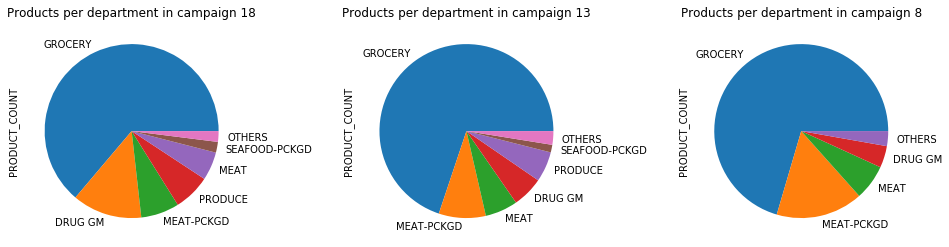

In [557]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(17,4))

tmp = coupon_trans[coupon_trans['CAMPAIGN'] == 18][['PRODUCT_ID']] \
      .merge(product, on='PRODUCT_ID').drop_duplicates() \
      .groupby('DEPARTMENT').count().rename(columns={'PRODUCT_ID': 'PRODUCT_COUNT'})[['PRODUCT_COUNT']] \
      .sort_values('PRODUCT_COUNT', ascending=False)
# Group departments with PRODUCT_COUNT < 10 as 'OTHERS'
others_count = sum(tmp[tmp['PRODUCT_COUNT'] < 10]['PRODUCT_COUNT'])
tmp = tmp[tmp['PRODUCT_COUNT']>=10]
tmp.loc['OTHERS'] = others_count
tmp.plot.pie(y = 'PRODUCT_COUNT', ax=ax1, title='Products per department in campaign 18', legend=None)

tmp = coupon_trans[coupon_trans['CAMPAIGN'] == 13][['PRODUCT_ID']] \
      .merge(product, on='PRODUCT_ID').drop_duplicates() \
      .groupby('DEPARTMENT').count().rename(columns={'PRODUCT_ID': 'PRODUCT_COUNT'})[['PRODUCT_COUNT']] \
      .sort_values('PRODUCT_COUNT', ascending=False)
# Group departments with PRODUCT_COUNT < 10 as 'OTHERS'
others_count = sum(tmp[tmp['PRODUCT_COUNT'] < 10]['PRODUCT_COUNT'])
tmp = tmp[tmp['PRODUCT_COUNT']>=10]
tmp.loc['OTHERS'] = others_count
tmp.plot.pie(y = 'PRODUCT_COUNT', ax=ax2, title='Products per department in campaign 13', legend=None)

tmp = coupon_trans[coupon_trans['CAMPAIGN'] == 8][['PRODUCT_ID']] \
      .merge(product, on='PRODUCT_ID').drop_duplicates() \
      .groupby('DEPARTMENT').count().rename(columns={'PRODUCT_ID': 'PRODUCT_COUNT'})[['PRODUCT_COUNT']] \
      .sort_values('PRODUCT_COUNT', ascending=False)
# Group departments with PRODUCT_COUNT < 10 as 'OTHERS'
others_count = sum(tmp[tmp['PRODUCT_COUNT'] < 10]['PRODUCT_COUNT'])
tmp = tmp[tmp['PRODUCT_COUNT']>=10]
tmp.loc['OTHERS'] = others_count
tmp.plot.pie(y = 'PRODUCT_COUNT', ax=ax3, title='Products per department in campaign 8', legend=None)

The distribution across departments seems to be dominated by `GROCERY`, followed by `MEAT-PCKGD`, but this also similar to the distribution of products across departments for the whole set of products.

We can now try to visualize how the `Predicted total sales increase` is distributed between departments.

In [14]:
scores.columns

Index(['Total sales before', 'Total sales after', 'Average sales before',
       'Average sales after', 'Average sales difference',
       'Predicted total sales increase', 'household_key', 'PRODUCT_ID', 'DAY',
       'COUPON_UPC', 'CAMPAIGN'],
      dtype='object')

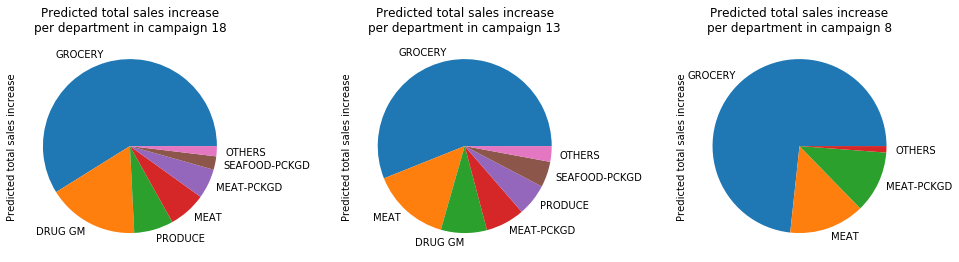

In [569]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(17,4))

tmp = scores[scores['CAMPAIGN'] == 18] \
      .merge(product, on='PRODUCT_ID') \
      .groupby('DEPARTMENT').sum()[['Predicted total sales increase']] \
      .sort_values('Predicted total sales increase', ascending=False)
# Group departments with 'Predicted total sales increase' < 100 as 'OTHERS'
others_value = sum(tmp[tmp['Predicted total sales increase'] < 100]['Predicted total sales increase'])
tmp = tmp[tmp['Predicted total sales increase']>=100]
tmp.loc['OTHERS'] = others_value
tmp.plot.pie(y = 'Predicted total sales increase', ax=ax1, title='Predicted total sales increase\nper department in campaign 18', legend=None)

tmp = scores[scores['CAMPAIGN'] == 13] \
      .merge(product, on='PRODUCT_ID') \
      .groupby('DEPARTMENT').sum()[['Predicted total sales increase']] \
      .sort_values('Predicted total sales increase', ascending=False)
# Group departments with 'Predicted total sales increase' < 100 as 'OTHERS'
others_value = sum(tmp[tmp['Predicted total sales increase'] < 100]['Predicted total sales increase'])
tmp = tmp[tmp['Predicted total sales increase']>=100]
tmp.loc['OTHERS'] = others_value
tmp.plot.pie(y = 'Predicted total sales increase', ax=ax2, title='Predicted total sales increase\nper department in campaign 13', legend=None)

tmp = scores[scores['CAMPAIGN'] == 8] \
      .merge(product, on='PRODUCT_ID') \
      .groupby('DEPARTMENT').sum()[['Predicted total sales increase']] \
      .sort_values('Predicted total sales increase', ascending=False)
# Group departments with 'Predicted total sales increase' < 100 as 'OTHERS'
others_value = sum(tmp[tmp['Predicted total sales increase'] < 100]['Predicted total sales increase'])
tmp = tmp[tmp['Predicted total sales increase']>=100]
tmp.loc['OTHERS'] = others_value
tmp.plot.pie(y = 'Predicted total sales increase', ax=ax3, title='Predicted total sales increase\nper department in campaign 8', legend=None)

# COUAC!!!

In [278]:
#Computing the mean score by family
individual_scores=scores.groupby('household_key').median()[['Predicted total sales increase']]\
.sort_values(by='Predicted total sales increase',ascending=False)
individual_scores.head()

,Predicted total sales increase
household_key,
2342.0,45.467903
1598.0,42.951484
1568.0,42.499080
80.0,31.960000
906.0,25.723233


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002B413514BA8>]],
      dtype=object)

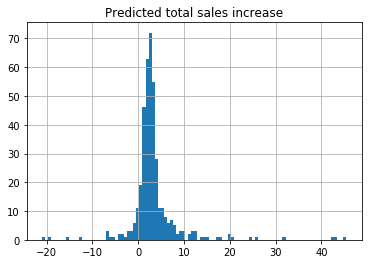

In [279]:
#Printing the distribution of the family scores
individual_scores.hist(bins=100)

In [280]:
#Combining the fimily scores with the demographic data to be able to study scores by demographics
#PS: We assume the demographic table is representative of the studied population
demo_with_scores=individual_scores.merge(demographic, left_index=True, right_on='household_key')
demo_with_scores.head()

,Predicted total sales increase,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key,AGE,MIN_INCOME,MAX_INCOME
753,45.467903,55-64,U,100-124K,Homeowner,Unknown,1,None/Unknown,2342,55,100,124
508,42.499080,55-64,B,35-49K,Homeowner,Single Female,1,None/Unknown,1568,55,35,49
30,31.960000,45-54,U,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,80,45,50,74
306,25.723233,55-64,A,Under 15K,Homeowner,Single Female,2,None/Unknown,906,55,0,15
688,20.473904,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,2156,45,50,74


In [276]:
#Combining all highest income brackets to create a new category with decent sample size
demo_with_scores['MAX_INCOME'] = np.where(demo_with_scores['MAX_INCOME'] > 175, 225, demo_with_scores['MAX_INCOME']) 

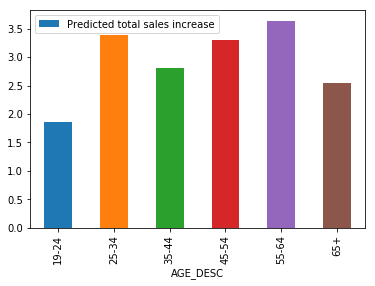

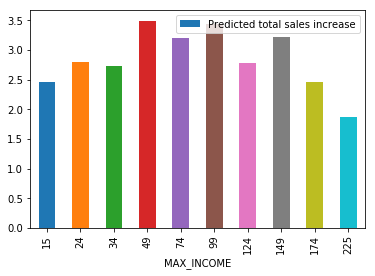

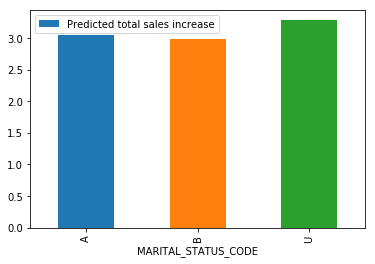

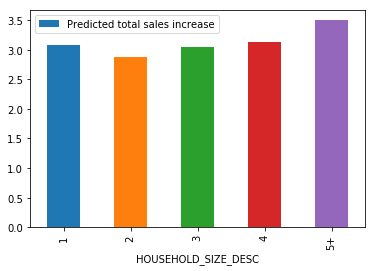

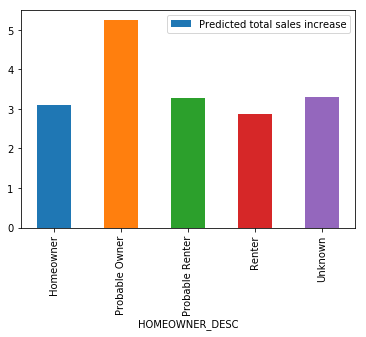

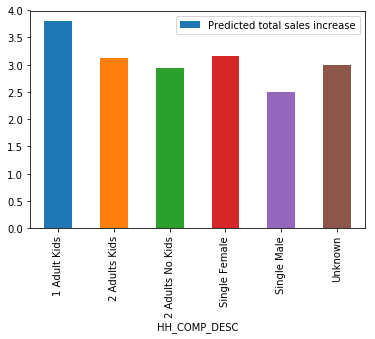

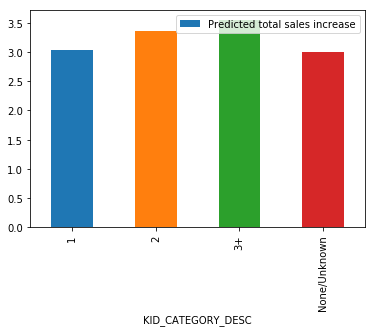

In [277]:
#Comparing the median score per category for each categorical demographic entry
#PS: 'Single Male' seems to be a negative indicator while 'Probable Owner', to be a positive indicator
demo_with_scores.groupby('AGE_DESC').median()[['Predicted total sales increase']].plot.bar(y='Predicted total sales increase')
#Using MAX_INCOME as a proxy for INCOME_DESC for convenience
demo_with_scores.groupby('MAX_INCOME').median()[['Predicted total sales increase']].plot.bar(y='Predicted total sales increase')
demo_with_scores.groupby('MARITAL_STATUS_CODE').median()[['Predicted total sales increase']].plot.bar(y='Predicted total sales increase')
demo_with_scores.groupby('HOUSEHOLD_SIZE_DESC').median()[['Predicted total sales increase']].plot.bar(y='Predicted total sales increase')
demo_with_scores.groupby('HOMEOWNER_DESC').median()[['Predicted total sales increase']].plot.bar(y='Predicted total sales increase')
demo_with_scores.groupby('HH_COMP_DESC').median()[['Predicted total sales increase']].plot.bar(y='Predicted total sales increase')
demo_with_scores.groupby('KID_CATEGORY_DESC').median()[['Predicted total sales increase']].plot.bar(y='Predicted total sales increase')

In [281]:
#Printing the amount of families par HOMEOWNER_DESC category to check wether the previous results are significant
#There are 6 point for 'Probable Owner', so the results are somewhat questionable
#but still probably trustworthy due to the use of the median
demo_with_scores.groupby('HOMEOWNER_DESC').count()

,Predicted total sales increase,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key,AGE,MIN_INCOME,MAX_INCOME
HOMEOWNER_DESC,,,,,,,,,,,
Homeowner,206,206,206,206,206,206,206,206,206,206,206
Probable Owner,6,6,6,6,6,6,6,6,6,6,6
Probable Renter,3,3,3,3,3,3,3,3,3,3,3
Renter,18,18,18,18,18,18,18,18,18,18,18
Unknown,57,57,57,57,57,57,57,57,57,57,57


In [283]:
#Printing the amount of families par HH_COMP_DESC category to check wether the previous results are significant
#There are 24 points for 'Single Male', so we can't really expect our results to be the consequence of outliers
demo_with_scores.groupby('HH_COMP_DESC').count()

,Predicted total sales increase,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key,AGE,MIN_INCOME,MAX_INCOME
HH_COMP_DESC,,,,,,,,,,,
1 Adult Kids,16,16,16,16,16,16,16,16,16,16,16
2 Adults Kids,75,75,75,75,75,75,75,75,75,75,75
2 Adults No Kids,92,92,92,92,92,92,92,92,92,92,92
Single Female,56,56,56,56,56,56,56,56,56,56,56
Single Male,24,24,24,24,24,24,24,24,24,24,24
Unknown,27,27,27,27,27,27,27,27,27,27,27


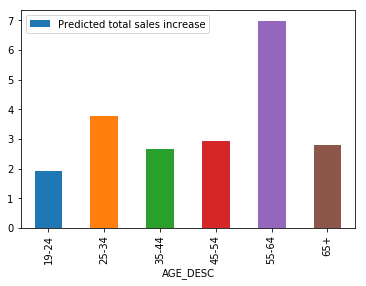

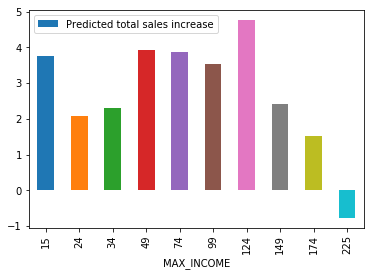

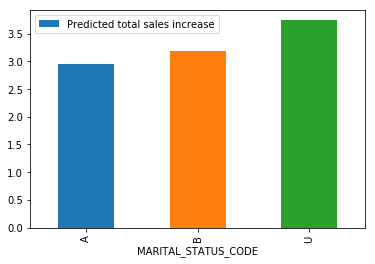

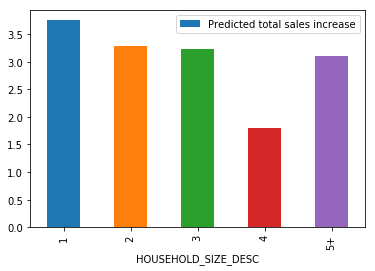

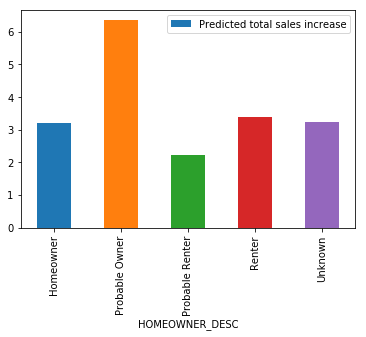

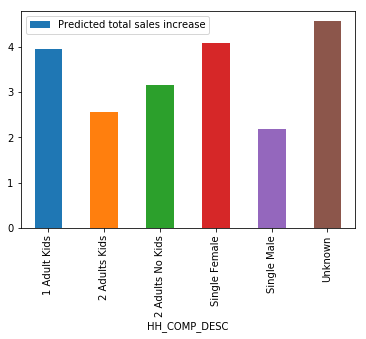

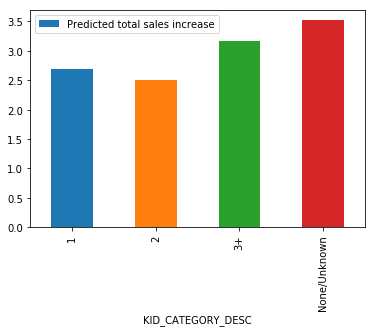

In [262]:
#Comparing the mean score per category for each categorical demographic entry
#PS: There seems to be outliers in the 55-64 year-range group
demo_with_scores.groupby('AGE_DESC').mean()[['Predicted total sales increase']].plot.bar(y='Predicted total sales increase')
#Using MAX_INCOME as a proxy for INCOME_DESC for convenience
demo_with_scores.groupby('MAX_INCOME').mean()[['Predicted total sales increase']].plot.bar(y='Predicted total sales increase')
demo_with_scores.groupby('MARITAL_STATUS_CODE').mean()[['Predicted total sales increase']].plot.bar(y='Predicted total sales increase')
demo_with_scores.groupby('HOUSEHOLD_SIZE_DESC').mean()[['Predicted total sales increase']].plot.bar(y='Predicted total sales increase')
demo_with_scores.groupby('HOMEOWNER_DESC').mean()[['Predicted total sales increase']].plot.bar(y='Predicted total sales increase')
demo_with_scores.groupby('HH_COMP_DESC').mean()[['Predicted total sales increase']].plot.bar(y='Predicted total sales increase')
demo_with_scores.groupby('KID_CATEGORY_DESC').mean()[['Predicted total sales increase']].plot.bar(y='Predicted total sales increase')

In [255]:
#Printing the amount of people in each age range to check if they're indicative samples.
#PS: The age range 55-64 is indicative.
demo_with_scores.groupby('AGE').count()

,Predicted total sales increase,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key,MIN_INCOME,MAX_INCOME
AGE,,,,,,,,,,,
19,9,9,9,9,9,9,9,9,9,9,9
25,47,47,47,47,47,47,47,47,47,47,47
35,74,74,74,74,74,74,74,74,74,74,74
45,115,115,115,115,115,115,115,115,115,115,115
55,23,23,23,23,23,23,23,23,23,23,23
65,22,22,22,22,22,22,22,22,22,22,22


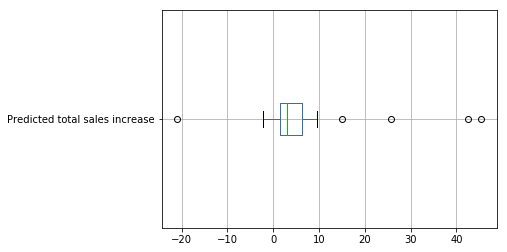

In [233]:
#Displaying a boxplot of the score for people with age range 55-64.
#PS: 4 outliers can be observed on the left side, one on the right.
demo_with_scores[demo_with_scores['AGE']==55][['Predicted total sales increase']].boxplot(column='Predicted total sales increase',vert=False)

C:\Users\ajlre\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


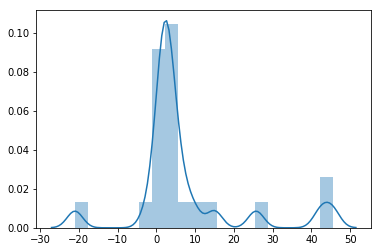

In [256]:
#Printing the score distribution of the positive outliers for people with age range 55-64.
x = demo_with_scores[demo_with_scores['AGE']==55][['Predicted total sales increase']]
sns.distplot(x)

In [258]:
#Getting the list of products the positive outliers used their coupons on.
#PS: nothing exceptional, toilet paper, ice cream and coffee...
outliers=demo_with_scores[demo_with_scores['AGE']==55].sort_values(by='Predicted total sales increase',ascending=False)[['household_key']][:4]
products_outliers=outliers.merge(coupon_trans,on='household_key')[['PRODUCT_ID', 'household_key']]
product.merge(products_outliers, left_index=True, right_on='PRODUCT_ID')

,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT,PRODUCT_ID,household_key
1,1046,GROCERY,National,COFFEE,GROUND COFFEE,33 OZ,882489,1568
2,864,GROCERY,National,MARGARINES,MARGARINE: TUBS AND BOWLS,8 OZ,1113141,906
0,2110,GROCERY,National,ICE CREAM/MILK/SHERBTS,PREMIUM,56 OZ,7166865,2342
3,764,GROCERY,National,LAUNDRY DETERGENTS,LIQUID LAUNDRY DETERGENTS,72 LOAD,7409999,1130


In [259]:
#Printing the demographic data of the outliers to check wether they have anything else in common.
#PS: nothing to see her either.
demo_with_scores[demo_with_scores['AGE']==55].sort_values(by='Predicted total sales increase',ascending=False)[:4]

,Predicted total sales increase,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key,AGE,MIN_INCOME,MAX_INCOME
753,45.467903,55-64,U,100-124K,Homeowner,Unknown,1,None/Unknown,2342,55,100,124
508,42.499080,55-64,B,35-49K,Homeowner,Single Female,1,None/Unknown,1568,55,35,49
306,25.723233,55-64,A,Under 15K,Homeowner,Single Female,2,None/Unknown,906,55,0,15
373,14.990000,55-64,U,25-34K,Renter,2 Adults Kids,3,1,1130,55,25,34


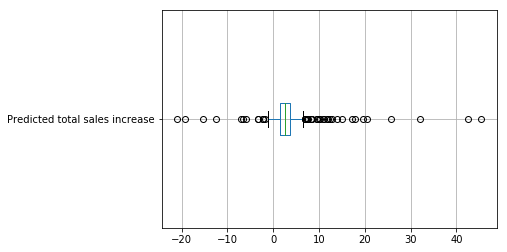

In [260]:
#Displaying the boxplot of scores for all the families with demographic data to extract the outliers.
#PS: Many outliers can be observed on both sides.
demo_with_scores[['Predicted total sales increase']].boxplot(column='Predicted total sales increase',vert=False)

In [265]:
#Extracting all positive outlier so to study their distribution
positive_outliers=demo_with_scores[demo_with_scores['Predicted total sales increase']>=10]
positive_outliers.head()

,Predicted total sales increase,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key,AGE,MIN_INCOME,MAX_INCOME
753,45.467903,55-64,U,100-124K,Homeowner,Unknown,1,None/Unknown,2342,55,100,124
508,42.499080,55-64,B,35-49K,Homeowner,Single Female,1,None/Unknown,1568,55,35,49
30,31.960000,45-54,U,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,80,45,50,74
306,25.723233,55-64,A,Under 15K,Homeowner,Single Female,2,None/Unknown,906,55,0,15
688,20.473904,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,2156,45,50,74


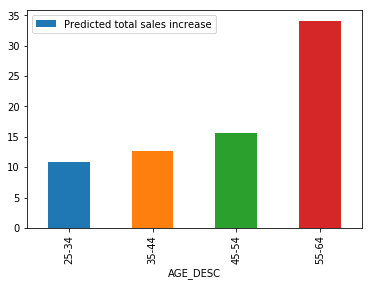

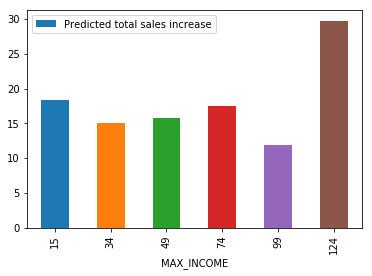

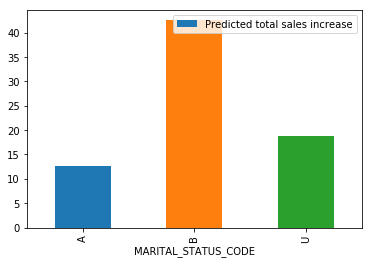

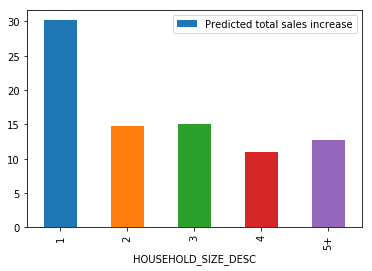

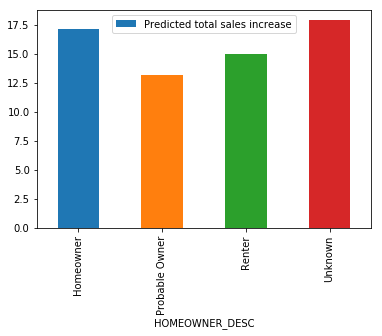

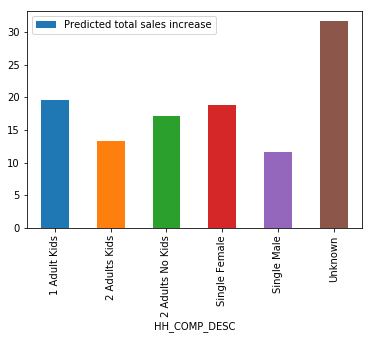

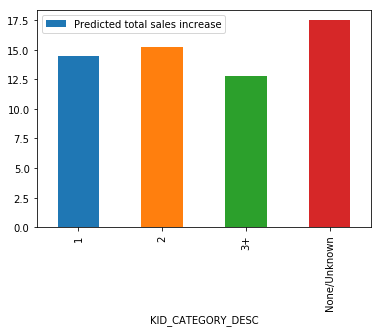

In [267]:
#Comparing the median score per category for each categorical demographic entry
#PS: there are many positive indicators such as being single with no children
positive_outliers.groupby('AGE_DESC').median()[['Predicted total sales increase']].plot.bar(y='Predicted total sales increase')
#Using MAX_INCOME as a proxy for INCOME_DESC for convenience
positive_outliers.groupby('MAX_INCOME').median()[['Predicted total sales increase']].plot.bar(y='Predicted total sales increase')
positive_outliers.groupby('MARITAL_STATUS_CODE').median()[['Predicted total sales increase']].plot.bar(y='Predicted total sales increase')
positive_outliers.groupby('HOUSEHOLD_SIZE_DESC').median()[['Predicted total sales increase']].plot.bar(y='Predicted total sales increase')
positive_outliers.groupby('HOMEOWNER_DESC').median()[['Predicted total sales increase']].plot.bar(y='Predicted total sales increase')
positive_outliers.groupby('HH_COMP_DESC').median()[['Predicted total sales increase']].plot.bar(y='Predicted total sales increase')
positive_outliers.groupby('KID_CATEGORY_DESC').median()[['Predicted total sales increase']].plot.bar(y='Predicted total sales increase')

In [268]:
#Extracting all negative outlier so to study their distribution
negative_outliers=demo_with_scores[demo_with_scores['Predicted total sales increase']<0]
negative_outliers.head()

,Predicted total sales increase,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key,AGE,MIN_INCOME,MAX_INCOME
716,-0.119855,65+,A,Under 15K,Homeowner,2 Adults No Kids,2,None/Unknown,2234,65,0,15
752,-0.137965,45-54,U,50-74K,Homeowner,Unknown,1,None/Unknown,2341,45,50,74
652,-0.167105,25-34,U,25-34K,Unknown,2 Adults No Kids,2,None/Unknown,2062,25,25,34
585,-0.213265,65+,A,75-99K,Homeowner,Single Female,2,None/Unknown,1850,65,75,99
389,-0.217560,35-44,U,50-74K,Homeowner,2 Adults Kids,4,2,1167,35,50,74


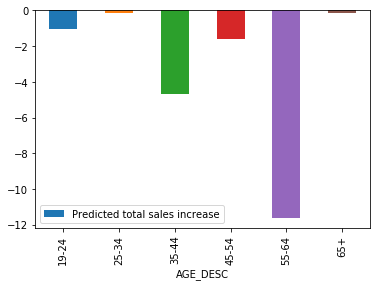

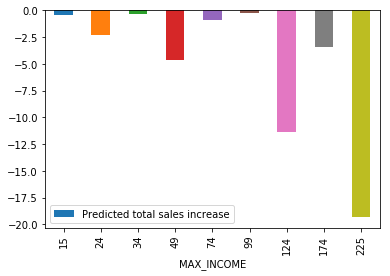

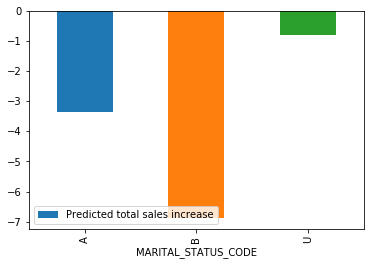

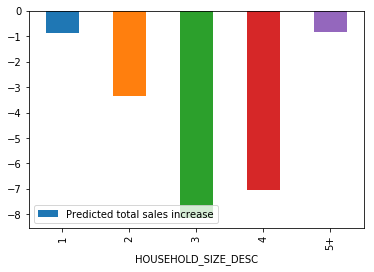

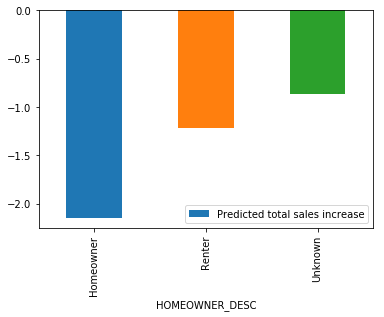

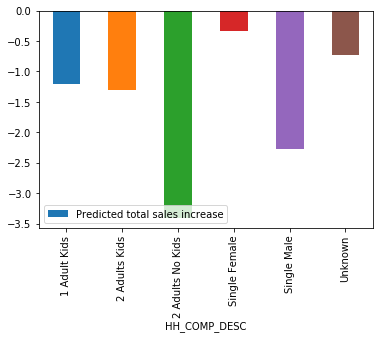

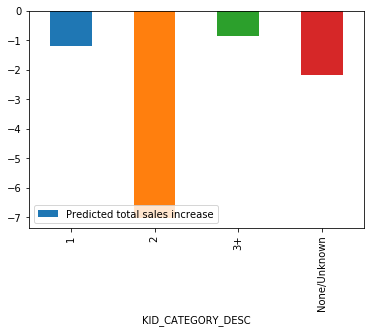

In [269]:
#Comparing the median score per category for each categorical demographic entry
#There are many positive indicators such as the top income bracket, home ownership or coupling with no kids
negative_outliers.groupby('AGE_DESC').median()[['Predicted total sales increase']].plot.bar(y='Predicted total sales increase')
#Using MAX_INCOME as a proxy for INCOME_DESC for convenience
negative_outliers.groupby('MAX_INCOME').median()[['Predicted total sales increase']].plot.bar(y='Predicted total sales increase')
negative_outliers.groupby('MARITAL_STATUS_CODE').median()[['Predicted total sales increase']].plot.bar(y='Predicted total sales increase')
negative_outliers.groupby('HOUSEHOLD_SIZE_DESC').median()[['Predicted total sales increase']].plot.bar(y='Predicted total sales increase')
negative_outliers.groupby('HOMEOWNER_DESC').median()[['Predicted total sales increase']].plot.bar(y='Predicted total sales increase')
negative_outliers.groupby('HH_COMP_DESC').median()[['Predicted total sales increase']].plot.bar(y='Predicted total sales increase')
negative_outliers.groupby('KID_CATEGORY_DESC').median()[['Predicted total sales increase']].plot.bar(y='Predicted total sales increase')

In [270]:
#Printing the list of negative outliers sorted by marital status to see if there are intersections between the positive indicators.
#PS: there is a big overlap between couples with no kids, home owners and married couples
negative_outliers.sort_values(by='MARITAL_STATUS_CODE')

,Predicted total sales increase,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key,AGE,MIN_INCOME,MAX_INCOME
716,-0.119855,65+,A,Under 15K,Homeowner,2 Adults No Kids,2,None/Unknown,2234,65,0,15
463,-15.400205,35-44,A,35-49K,Homeowner,2 Adults Kids,3,1,1430,35,35,49
542,-6.512686,35-44,A,150-174K,Homeowner,Single Male,2,None/Unknown,1710,35,150,174
409,-5.984961,35-44,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1247,35,35,49
573,-3.438545,45-54,A,150-174K,Homeowner,2 Adults No Kids,2,None/Unknown,1820,45,150,174
79,-3.362000,35-44,A,35-49K,Unknown,2 Adults No Kids,2,None/Unknown,222,35,35,49
451,-2.143759,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,1394,45,50,74
731,-19.350220,45-54,A,250K+,Homeowner,2 Adults No Kids,2,None/Unknown,2284,45,250,225
28,-1.730034,35-44,A,100-124K,Homeowner,2 Adults Kids,5+,3+,77,35,100,124
241,-0.364210,45-54,A,25-34K,Homeowner,2 Adults Kids,5+,3+,718,45,25,34


In [212]:
#Computing the score for each product of the negative outliers which represent maried homeowners with no kids to check 
#wether any kind of weird behavior can be observed.
#PS: nothing weird, so let's look at the actual products
neg_out_prod_scores=scores[['household_key','PRODUCT_ID','Average sales before','Average sales after','Predicted total sales increase']].merge(general_outliers[['household_key']],on='household_key')
neg_out_prod_scores.sort_values(by='Predicted total sales increase').head()

,household_key,PRODUCT_ID,Average sales before,Average sales after,Predicted total sales increase
43,2448.0,7168058.0,0.900240,0.024407,-103.348288
23,1923.0,1090017.0,0.146923,0.020823,-52.079231
94,389.0,1089024.0,0.300202,0.078116,-45.971818
119,2284.0,12262778.0,0.207799,0.062028,-41.690440
109,389.0,1126899.0,0.733135,0.397565,-38.590553
60,1337.0,5569230.0,0.411875,0.067830,-36.468750
197,2364.0,1817725.0,0.306739,0.024701,-32.998478
166,1357.0,862349.0,0.190476,0.063241,-32.190476
116,56.0,6533608.0,0.209568,0.102852,-31.054259
118,56.0,9803545.0,0.238190,0.165467,-21.016963


In [272]:
#Finding the list of products corresponding to the previous transactions with negative score
#then grouping them by department to see if weird disproportions can be found
#PS: We see that there's a disproportionate amount of groceries.
neg_out_prod=neg_out_prod_scores[neg_out_prod_scores['Predicted total sales increase']<0][['PRODUCT_ID']]\
.merge(product.reset_index()[['PRODUCT_ID', 'DEPARTMENT', 'SUB_COMMODITY_DESC']],on='PRODUCT_ID')
neg_out_prod.groupby('DEPARTMENT').count()

,PRODUCT_ID,SUB_COMMODITY_DESC
DEPARTMENT,,
DRUG GM,2,2
GROCERY,77,77
MEAT,3,3
MEAT-PCKGD,7,7
PASTRY,1,1
PRODUCE,3,3
